# 毕业论文`GRAD`
## `CMAQ`模拟效果验证

---
*@author: Evan*\
*@date: 2023-12-19*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
from mask import polygon_to_mask
import ModelEvalLib as me

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
years = [2019,2021,2022]
month = 'Jul'

simvar = 'O3'
obsvar = 'O3'

In [3]:
def plot_line_short(year,mean_obs,mean_sim,mb,r,rmse):
    fig = plt.figure(figsize=(18,6),dpi=300)
    ax = fig.subplots(1,1)

    xx = np.arange(0,np.size(mean_obs,0),1)
    ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax.set_xlim([0,np.size(mean_obs,0)-1])
    ax.set_xticks(xx[::24])
    STR = get_STR(year,month)
    END = get_END(year,month)
    ax.set_xticklabels(pd.date_range(STR,END,freq='D').strftime('%m-%d'))#,rotation=45)

    strdict = {'fontsize':16,'fontweight':'bold'}
    ax.set_xlabel('Date',fontdict=strdict)
    ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
    ax.set_title('(a)',loc='left',fontdict=strdict)
    ax.legend(loc=2)

    # ===========
    # add metrics
    mb_str   = '{:.2f}'.format(mb)
    r_str    = '{:.2f}'.format(r)
    rmse_str = '{:.2f}'.format(rmse)

    ax.text(0.73,1.01,f'R = {r_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    ax.text(0.85,1.01,f'MB = {mb_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    ax.text(0.99,1.01,f'RMSE = {rmse_str}',transform=ax.transAxes,fontdict=strdict,ha='right')

    plt.savefig(f'D:/Academic/Project/GRAD/Seasonally/figures/模拟验证/{simvar}_{year}.png',dpi=300,bbox_inches='tight')
    plt.close()

In [7]:
def plot_line_long(year,mean_obs,mean_sim):
    fig = plt.figure(figsize=(24,3),dpi=300)
    ax = fig.subplots(1,1)

    xx = np.arange(0,np.size(mean_obs,0),1)
    ax.plot(xx,mean_sim,color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax.plot(xx,mean_obs,color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax.set_xlim([0,np.size(mean_obs,0)-1])
    ax.set_xticks(xx[::24])
    STR = get_STR(year,month)
    END = get_END(year,month)
    ax.set_xticklabels(pd.date_range(STR,END,freq='D').strftime('%m-%d'))#,rotation=45)

    strdict = {'fontsize':16,'fontweight':'bold'}
    ax.set_xlabel('Date',fontdict=strdict)
    ax.set_ylabel('O$_3$ ($\mu$g/m$^3$)',fontdict=strdict)
    if year == 2019:
        title = '(a)'
    elif year == 2021:
        title = '(b)'
    elif year == 2022:
        title = '(c)'
    ax.set_title(title,loc='left',fontdict=strdict)
    ax.legend(loc=2)

    # ===========
    # add metrics
    # mb_str   = '{:.2f}'.format(mb)
    # r_str    = '{:.2f}'.format(r)
    # rmse_str = '{:.2f}'.format(rmse)

    # ax.text(0.73,1.01,f'R = {r_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    # ax.text(0.85,1.01,f'MB = {mb_str}',transform=ax.transAxes,fontdict=strdict,ha='right')
    # ax.text(0.99,1.01,f'RMSE = {rmse_str}',transform=ax.transAxes,fontdict=strdict,ha='right')

    plt.savefig(f'D:/Academic/Project/GRAD/Seasonally/figures/模拟验证/without_metrics/{simvar}_{year}.png',dpi=300,bbox_inches='tight')
    plt.close()

In [6]:
def print_metrics(sim,obs):
    metrics = me.CalculateMetrics(obs,sim)
    mb   = metrics.get_mb().values
    r    = metrics.get_r()
    rmse = metrics.get_rmse().values
    ioa  = metrics.get_ioa().values
    nmb  = metrics.get_nmb().values
    nme  = metrics.get_nme().values
    print('MB  : ',mb,'\nR   : ',r,'\nRMSE: ',rmse,'\nIOA : ',ioa,'\nNMB : ',nmb,'\nNME : ',nme)
  

In [8]:
for year in years:
    print(f'Year = {year}')

    # Simulation data
    ds = xr.open_dataset(datadir + f'processed/{month}_{year}/{month}_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]
    shp = gpd.read_file(shp_files['PRD_merge_adm'])
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)
    sim = mean_sim.rolling(time=8).mean().resample(time='D').max()
    
    # Observation data
    obspath = get_obspath(month)
    df = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
    mean_obs = df.mean(axis=1,skipna=True)
    inteobs = mean_obs.interpolate(method='linear')
    obs = inteobs.rolling(8).mean().resample('D').max()
    print('-'*5+'Hour'+'-'*5)
    print_metrics(mean_sim,inteobs)
    print('-'*5+'MDA8'+'-'*5)
    print_metrics(sim,obs)
    
    sim90 = sim.quantile(0.9).values
    obs90 = obs.quantile(0.9)
    mb90 = sim90 - obs90
    print(f'MDA8 90per  :  {mb90}')
    
    # plot_line_short(year,mean_obs,mean_sim,mb,r,rmse)
    plot_line_long(year,mean_obs,mean_sim)
    print('='*20)
    
    

Year = 2019
-----Hour-----
MB  :  34.41192981286126 
R   :  0.8096896976535256 
RMSE:  40.20076660479849 
IOA :  0.7277186888188651 
NMB :  70.98637204829353 
NME :  82.9278273655052
-----MDA8-----
MB  :  37.212989222113265 
R   :  0.7721607282375037 
RMSE:  42.77799708123854 
IOA :  0.6074259449183202 
NMB :  44.54793561627534 
NME :  51.209846336015694
MDA8 90per  :  29.393772880110163
Year = 2021
-----Hour-----
MB  :  24.07180156515639 
R   :  0.8693828707033949 
RMSE:  31.413419667171507 
IOA :  0.8462694349953489 
NMB :  41.132562320450255 
NME :  53.677513029548564
-----MDA8-----
MB  :  21.26510564294443 
R   :  0.8230247069072075 
RMSE:  30.676664153860873 
IOA :  0.7479668550808505 
NMB :  21.266892668180567 
NME :  30.67924208476439
MDA8 90per  :  -10.734403849471164
Year = 2022
-----Hour-----
MB  :  19.027574813140006 
R   :  0.8790755703633479 
RMSE:  29.143221846983675 
IOA :  0.8948556557418099 
NMB :  30.68366472110692 
NME :  46.996049513790744
-----MDA8-----
MB  :  21.6

---

In [3]:
sim = {}
obs = {}
for year in years:
    ds = xr.open_dataset(datadir + f'processed/{month}_{year}/{month}_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]
    shp = gpd.read_file(shp_files['PRD_merge_adm'])
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    mean_sim    = masked_sim.mean(dim=('x','y'),skipna=True)

    # Observation data
    obspath = get_obspath(month)
    df = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
    mean_obs = df.mean(axis=1,skipna=True)
    
    sim[year] = mean_sim
    obs[year] = mean_obs


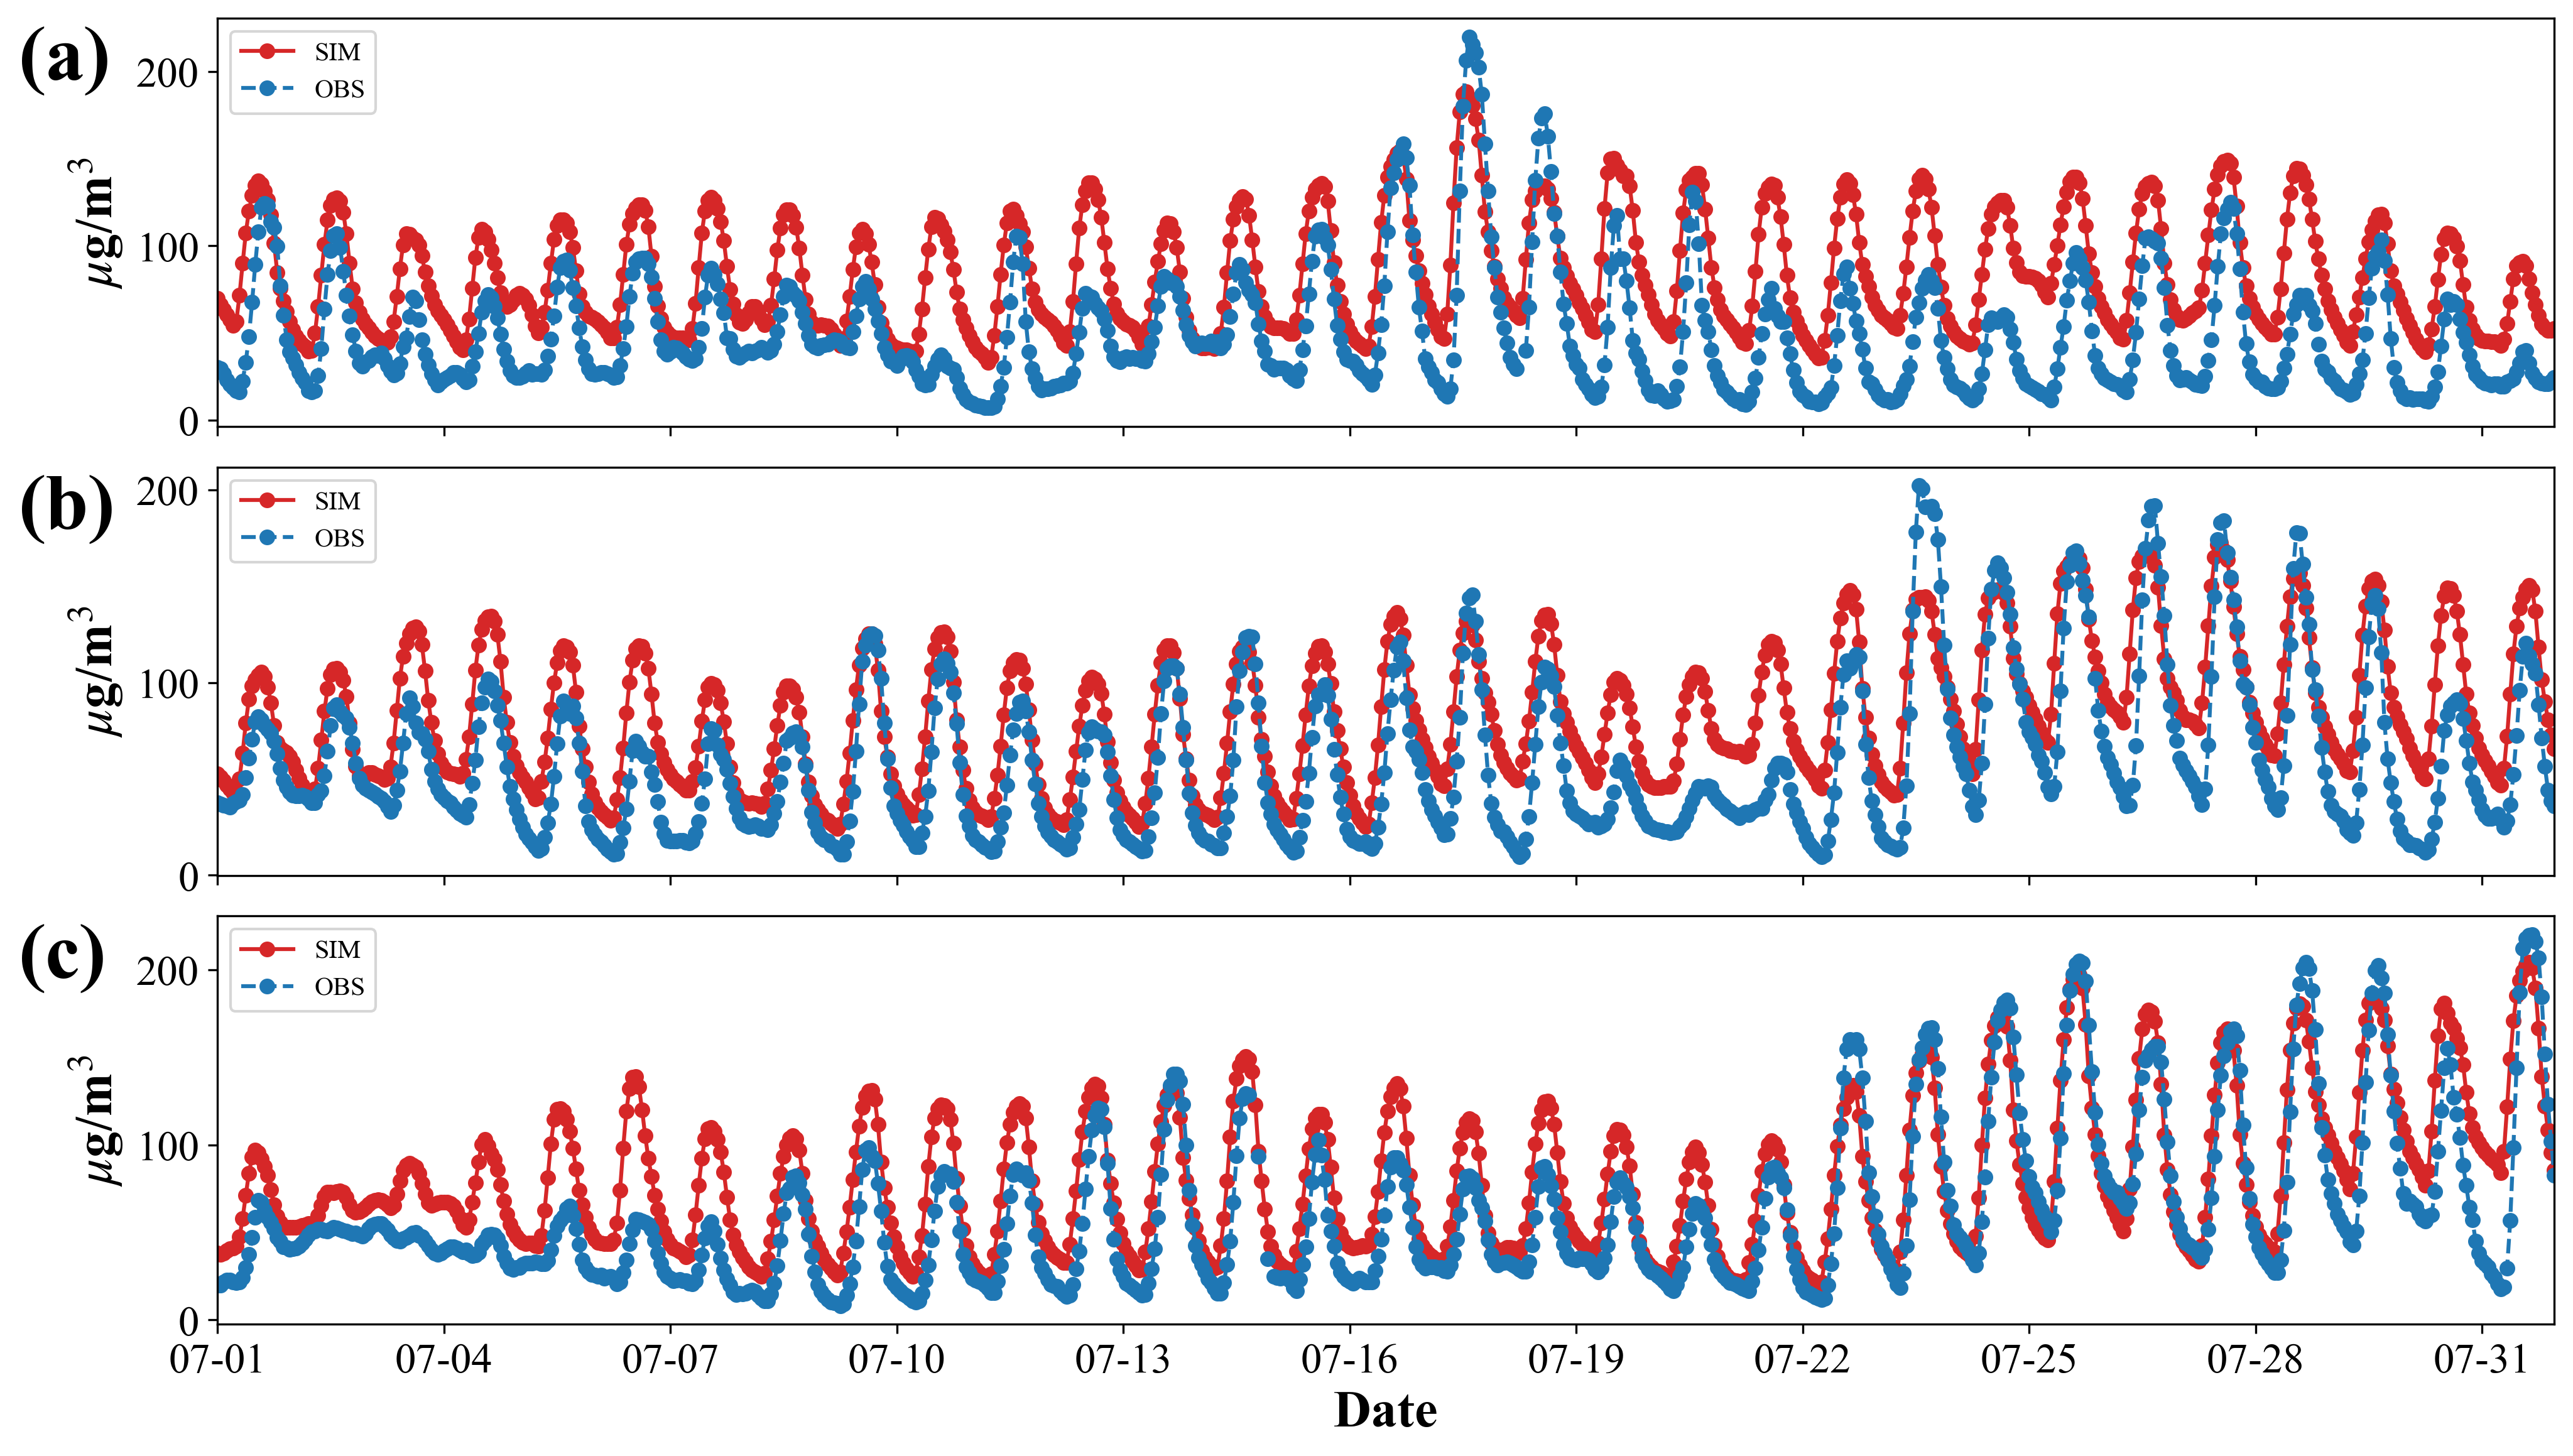

In [4]:
strdict = {'fontsize':20,'fontweight':'bold'}
strdict2 = dict(fontsize=30,fontweight='bold',)
titles = ['(a)','(b)','(c)']

fig = plt.figure(figsize=(16,9),dpi=300)
ax = fig.subplots(3,1)

xx = np.arange(0,np.size(mean_obs,0),1)

for i,year in enumerate(years[:3]):
    ax[i].plot(xx,sim[year],color='tab:red',label='SIM',linestyle='-', marker='.',markersize=10)
    ax[i].plot(xx,obs[year],color='tab:blue',label='OBS',linestyle='--',marker='.',markersize=10)

    ax[i].set_xlim([0,np.size(mean_obs,0)-1])
    ax[i].set_xticks(xx[::24*3])
    STR = get_STR(year,month)
    END = get_END(year,month)
    # ax[i].set_yticklabels(ax[i].get_yticks(),fontsize=16)
    ax[i].tick_params(axis='y',labelsize=16)
    if i ==2:
        ax[i].set_xticklabels(pd.date_range(STR,END,freq='3D').strftime('%m-%d'),fontsize=16)
        ax[i].set_xlabel('Date',fontdict=strdict)
    else:
        ax[i].set_xticklabels('')
        ax[i].set_xlabel('')
    ax[i].set_ylabel('$\mu$g/m$^3$',fontdict=strdict)

    ax[i].text(-0.085,0.85,titles[i],transform=ax[i].transAxes,fontdict=strdict2)
    ax[i].legend(loc=2)
plt.subplots_adjust(hspace=0.1)
plt.show()